# This notebook sets an absorption line, which we will reproduce with forward modeling

Simple proof of concept modeling.

We want to predict the metallicity of a system by assuming that gas is distributed along all of line of sight assuming some radial profile. And from that teasing out the metallicity.

Written By:  Rongmon Bordoloi
             Feb 22, 2019

Tested on: Python 3.7



In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from importlib import reload

from rbvfit import model as m
reload(m)

<module 'rbvfit.model' from '/Users/bordoloi/WORK/python/rbvfit/src/rbvfit/model.py'>

## Set up a wavelength grid 
Using 0.01 Angstrom/ pixel similar to COS spectra

In [2]:
wave=np.arange(1520.,1538.,0.01)

In [3]:
# We are setting up 3 clumps at z = 0
#  For SiII 1526 absorption
# . With default 6.5 pixel FWHM of HST/COS and Gaussian convolution
zabs=np.array([0.,0., 0.])
lambda_rest = 1526.9 * np.ones((len(zabs),))

s=m.create_voigt(zabs,lambda_rest)

In [4]:
N=np.array([14.,13., 16.])
b=np.array([20.,21.,29.])
v=np.array([10.,-100.,-200.])
theta=np.concatenate((N,b,v))

outflux= s.model_flux(theta,wave)

# Add error

flx= outflux + np.random.normal(0., .1, len(wave))


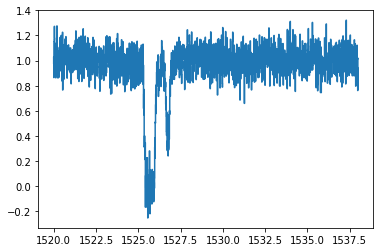

In [5]:
plt.step(wave,flx)

# Now write a model that will create an absorption profile as a function of distance along the line of sight

This will be a model assuming some arbitary density profile and a constant radial outflow velocity. We will try to constrain the slope of the density profile.

Text(0, 0.5, 'log Number density')

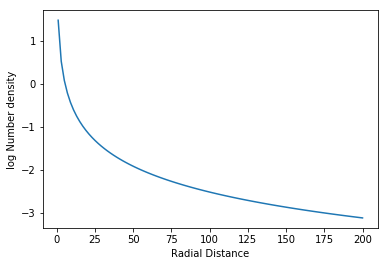

In [6]:
# Create a density profile going as R^-2

def density_profile(R,alpha=-2.):
    Rho_0= 5e-4
    rho= Rho_0 * (R/245.)**(alpha)
    return rho

def projected_vel(los,IP,vel):
    angle=np.zeros((len(los),))
    v_proj=angle
    for i in range(0,len(los)):
        # Computing projected velocity for a given model
        u = np.array([los[i],IP])
        v = np.array([1.,0.])
        c = np.dot(u,v)/np.linalg.norm(u)/np.linalg.norm(v) # -> cosine of the angle
        angle[i] = np.arccos(np.clip(c, -1, 1)) # if you really want the
    v_proj=vel*np.cos(np.deg2rad(np.rad2deg(angle)))
    return v_proj


R=np.linspace(1,200,100)

plt.plot(R,np.log10(density_profile(R)),'-')
#plt.plot(R,np.log10(velocity_profile(R)),'-')
plt.xlabel('Radial Distance')
plt.ylabel('log Number density')

# Now create a line of sight at an arbitary impact parameter

In [9]:
los=np.arange(-100.,100.,1)
def estimate_parameter(alpha, IP, solar, f_c, vel_const,los,Temp= 1e4):
    no_cell=len(los)

    
    
    #IP=30. # kpc
    # Assuming a spherically symmetric distribution compute distance from center to each point
    
    R= np.sqrt( (los**2.) + (IP**2.))
    rho=density_profile(R,alpha=alpha)    
    
    # Now convert the number density to actual ion number density 
    # Set metallicity
    O_H_Solar    = 10.**(-3.31);
    C_H_Solar    = 10.**(-3.61);
    Ne_H_Solar   = 10.**(-4.00);
    N_H_Solar    = 10.**(-4.07);
    Si_H_Solar   =10.**(-4.46);
    Mg_H_Solar   =10.**(-4.46);
    
    KBOLTZMANN = 1.3806488e-16;
    
    # Atomic Mass unit, grams.
    AMU = 1.6605388*10.**(-24.);
    kmpsToCmps = 1.0*10.**(5.);
    oxygenMass   = 15.999 * AMU;
    carbonMass   =  6.000 * AMU;
    neonMass     = 10.000 * AMU;
    nitrogenMass = 7.000 * AMU;
    silliconMass = 14.00 * AMU;
    magnesiumMass= 12.00 *AMU; 
    
    X_mass= silliconMass
    X_H_Solar= Si_H_Solar

    # Compute b assuming it is thermal and all cells are at same temperature
    b = np.ones((no_cell,))* (1.0*10.**(-5.)*np.sqrt(2.0 *KBOLTZMANN * Temp / X_mass))

    
    metallicity = solar*X_H_Solar
    # Set ionization fraction
    rho_ion= (rho * metallicity* f_c * rho) + 1e-99*np.ones(no_cell,)    
    
    vel=vel_const*np.ones(no_cell,)
    vel_p=projected_vel(los,IP,vel)
    
    kpc2cm=3.086e+21
    los_cm=los*kpc2cm
    col_per_cell=rho_ion*(los_cm[10]-los_cm[9])
    
    logN=np.log10(col_per_cell)

    
    return logN, b, vel_p


    
    


[0. 0. 0.]


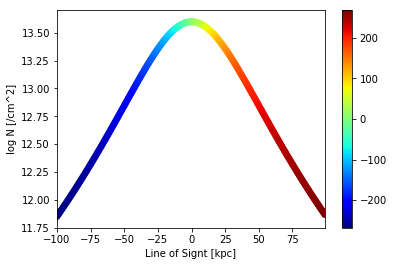

In [22]:
alpha= -2.5
IP= 50.
solar =1.05
f_c = 0.5
vel_const = 300.
Temp= 3e4
logN, b, vel_p= estimate_parameter(alpha, IP, solar, f_c, vel_const,los,Temp= Temp)
    
plt.scatter(los,logN,c=vel_p,cmap='jet')
plt.colorbar()


plt.xlabel('Line of Signt [kpc]')
plt.ylabel('log N [/cm^2]')
plt.xlim([np.min(los),np.max(los)])
#plt.ylim([-8,-4])

kpc2cm=3.086e+21
los_cm=los*kpc2cm

#col_per_cell=rho_ion*(los_cm[10]-los_cm[9])


#print(np.trapz(rho_ion,x=los_cm)*1e-13)
#print(np.sum(col_per_cell))
print(zabs)

# Generate Synthetic Spectrum
This part is computationally expensive

In [23]:
zabs=np.zeros((len(los),))
lambda_rest = 1526.9 * np.ones((len(zabs),))

s=m.create_voigt(zabs,lambda_rest)


In [24]:
theta=np.concatenate((logN,b,vel_p))

outflux= s.model_flux(theta,wave)

# Add error

fnorm= outflux + np.random.normal(0., .02, len(wave))

enorm= 0.02 * np.ones((len(wave),))


(0.0, 1.2)

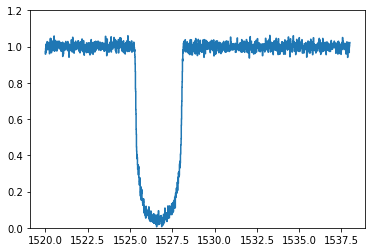

In [25]:
plt.step(wave,fnorm)
plt.ylim([0.,1.2])


# Create a wrapper routine to compute model spectrum

In [26]:
def model_guess(beta,wave):
    alpha= beta[0]
    IP = 50. # Fixed
    solar=beta[1]
    f_c = beta[2]
    vel_const = beta[3]
    Temp = 3e4 # Fixed
    
    logN, b, vel_p= estimate_parameter(alpha, IP, solar, f_c, vel_const,los,Temp= Temp)
    theta=np.concatenate((logN,b,vel_p))
    outflux= s.model_flux(theta,wave)
    
    return outflux

In [27]:
alpha= -2.5
solar =0.05
f_c = 0.5
vel_const = 300.



beta= [alpha, solar, f_c, vel_const]
fx = model_guess(beta,wave)


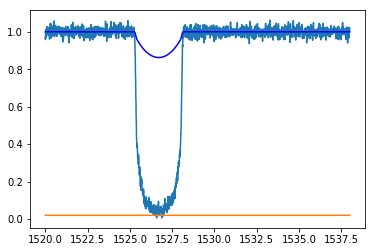

In [30]:
plt.plot(wave,fnorm)
plt.plot(wave,enorm)

plt.plot(wave,fx,'b')


# Try a stupid MCMC step to try to solve this problem


In [31]:
import emcee
import corner
import scipy.optimize as op
import sys

In [32]:
######## Computing Likelihoods######
def lnprior(theta, lb, ub):
    for index in range(0, len(lb)):
        if (lb[index] > theta[index]) or (ub[index] < theta[index]):
            return -np.inf
            break
    return 0.0


def lnlike(theta, model, x, y, yerr):
    model = model(theta, x)
    inv_sigma2 = 1.0 / (yerr ** 2)
    return -0.5 * (np.sum((y - model) ** 2 * inv_sigma2 - np.log(inv_sigma2)))


def lnprob(theta, lb, ub, model, x, y, yerr):
    lp = lnprior(theta, lb, ub)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, model, x, y, yerr)


def optimize_guess(model, theta, lb, ub, x, y, yerr):
    nll = lambda *args: -lnprob(*args)
    result = op.minimize(nll, [theta], args=(lb, ub, model, x, y, yerr))
    p = result["x"]
    return p

In [33]:
alpha= -2.5
solar =0.05
f_c = 0.5
vel_const = 300.



beta= [alpha, solar, f_c, vel_const]
lb = [-3.5, 0.01, 0.1, 100.]
ub=[-1.5,1.4,1.,400.]


In [113]:
print('Optimizing Guess ***********')
popt = optimize_guess(model_guess, beta, lb, ub, wave, fnorm, enorm)

Optimizing Guess ***********


In [128]:
perturbation=1e-6
no_of_Chain=50
no_of_steps=1000

length_of_lb = len(lb)
ndim, nwalkers = length_of_lb, no_of_Chain


guesses = [popt + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
print("Starting emcee ***********")
burntime = np.round(no_of_steps * .2)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8, args=(lb, ub, model_guess, wave, fnorm, enorm))
print("Start Burntime Calculations ***********")



import sys
width = 30
#First Burning some steps
pos, prob, state = sampler.run_mcmc(guesses, burntime)
sampler.reset()
print("Done Burning Steps!")
print("Now starting the Final Calculations:")
print("*****************")
#Now Running mcmc
for i, result in enumerate(sampler.sample(pos, iterations=no_of_steps)):
    n = int((width+1) * float(i) / no_of_steps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")

Starting emcee ***********
Start Burntime Calculations ***********
Start Burntime Calculations...
Done Burning Steps!
Now starting the Final Calculations:
*****************
[##############################]


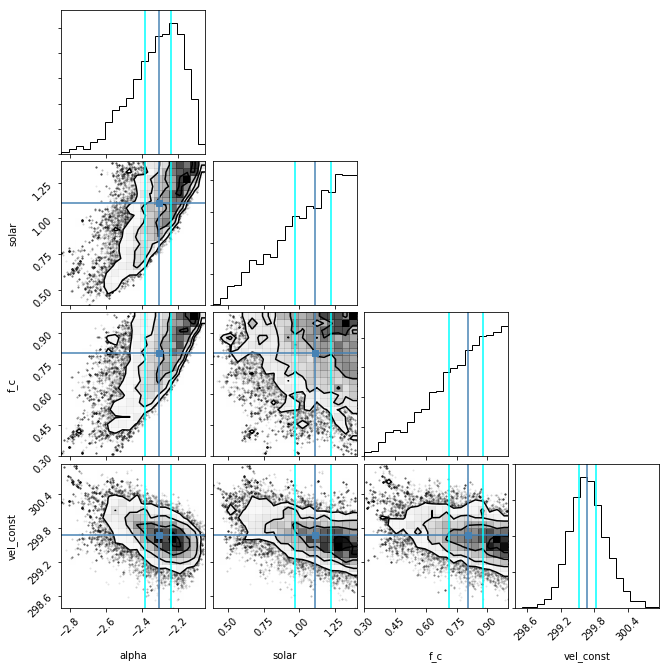

In [129]:
samples=sampler.chain[:, 100:, :].reshape((-1, ndim))#sampler.flatchain
st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
#df = pd.DataFrame(samples)
#temp=df.mode()
#st=temp.values[0]


text_label=['alpha', 'solar', 'f_c', 'vel_const']
figure=corner.corner(samples, labels=text_label, truths=st)
theta_prime=st


value1 =np.percentile(samples,32,axis=0)

# This is the empirical mean of the sample:
value2 = np.percentile(samples,68,axis=0)
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="aqua")
    ax.axvline(value2[i], color="aqua")

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi],color="aqua")
        ax.axvline(value2[xi],color="aqua")
        #ax.axhline(value1[yi], color="g")
        #ax.axhline(value2[yi], color="r")
        #ax.plot(value1[xi], value1[yi], "sg")
        #ax.plot(value2[xi], value2[yi], "sr")

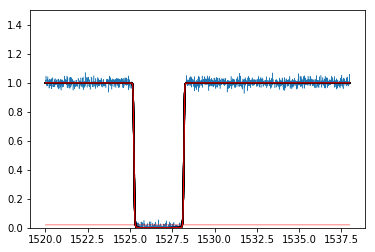

In [130]:

best_fit = model_guess(theta_prime,wave)

plt.step(wave,fnorm,linewidth=0.5)
plt.step(wave,enorm,color='r',linewidth=0.5)

## Plot random solutions
index=np.random.randint(0,high=len(samples), size=100)
for i in range(len(index)):
	plt.plot(wave,model_guess(samples[index[i],:],wave),color="k", alpha=0.1)

#plt.xlim([-500,1200])
plt.ylim([0,1.5])
plt.plot(wave,best_fit,color='r',linewidth=1)



([-2.5, 0.05, 0.5, 300.0],
 array([ -2.17543029,   1.0937136 ,   0.993676  , 299.53131267]))